# Cmael shower finder (ie showers that have a dip in the middle of the longitudinal profile)

In [38]:
%load_ext autoreload
%autoreload 2
import sys
import os
import random


import numpy as np
import pandas as pd
import uproot
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("../..")

from event_visualizer.event_index import EventLoader
from event_visualizer.notebook_visualizer import EventDisplay
from ntupleReaders.computation import computeAllFromTree
from locateEvents.utils import printDashLinksFromDf

from longitudinalProfile.camel.driver import CamelFinderDriver
from longitudinalProfile.camel.plot import plotIndividualProfile_scipy
from longitudinalProfile.camel.peak_finding import MakePeaksDfComputation
from longitudinalProfile.camel.filtering import FilterLowBaseHeight, FilterIsolatedPeaks, FilterNoisyCellsPeaks, FilterApplier, extractMostProminentPeak

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
driver_data = CamelFinderDriver("data", "cmssw", "v40")

In [42]:
driver_data.findPeaks()

  0%|          | 0/272855 [00:00<?, ?it/s]

Efficiency : 33.2%


In [43]:
driver_data.addInfoToPeaks()

In [44]:
driver_data.applyFilters()

FilterLowBaseHeight - efficiency 15.4%
FilterLargeNarrowPeaks - efficiency 99.6%


In [45]:
driver_data.extractMostProminentPeak()

In [46]:
driver_data.makeHistogram()

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  Regular(20, 0, 8, name='dipLengthMedian', label='Length of dip, at median height (in layers)'),
  Regular(30, 0, 0.07, name='dipRelativeProminence', label='Dip prominence as fraction of beam energy'),
  storage=Double()) # Sum: 13885.0 (13909.0 with flow)

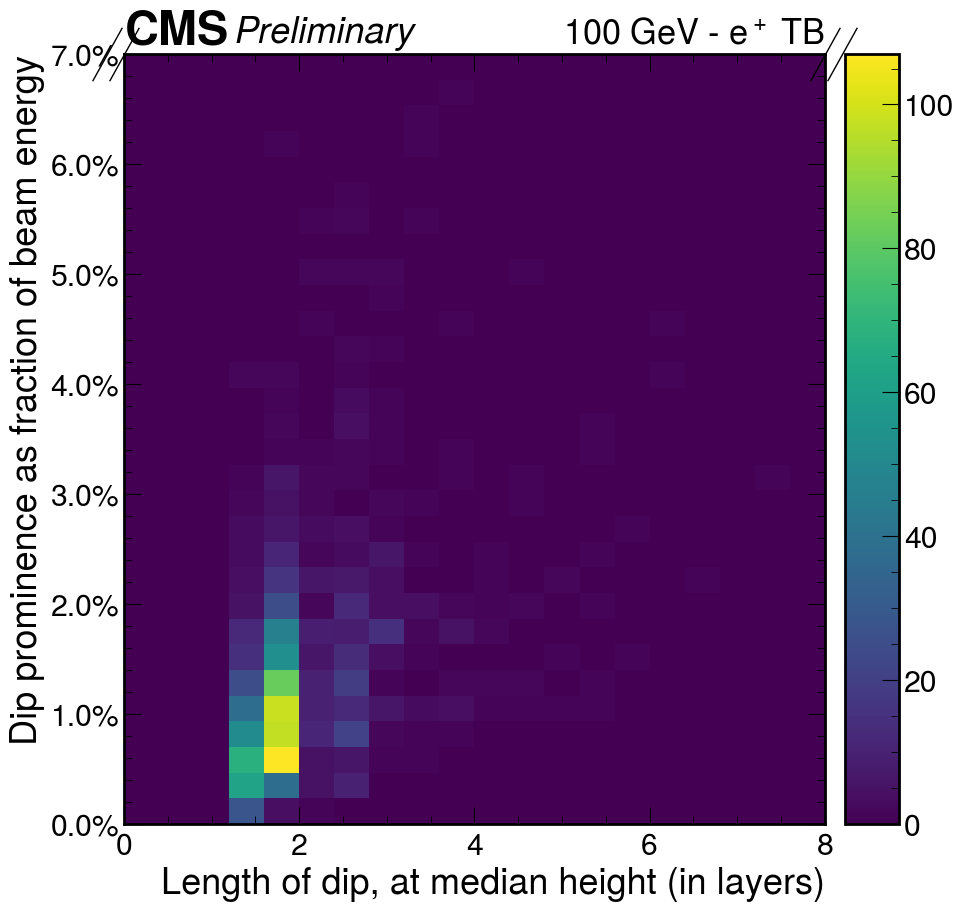

In [50]:
driver_data.plotHistogram(100)

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v40'
#clueParams = "single-file"
clueParams = "cmssw"
datatype = "data"

In [3]:
clueClustersFile = os.path.join(hist_folder, clueParams, datatype, "CLUE_clusters.root")
tree = uproot.open(clueClustersFile + ":clusters")
eventLoader = EventLoader(clueClustersFile)

In [4]:
settings=dict(distance=5,  width=1.5)

In [5]:
peaksDf_comp = MakePeaksDfComputation(settings)
computeAllFromTree(tree, [peaksDf_comp])

  0%|          | 0/272855 [00:00<?, ?it/s]

In [6]:
peaks_df, energyPerLayer_df = peaksDf_comp.getResult()

In [7]:
# Add rechits_energy_maxLayer column, which has the energy of the maximum layer energy
peaks_df = peaks_df.join(energyPerLayer_df.rechits_energy_sum_perLayer.groupby("eventInternal").max().rename("rechits_energy_maxLayer"))

In [8]:
energyPerLayer_df

rechits_energy_sum_perLayer  rechits_energy_sum   
eventInternal rechits_layer                                                    
0             1                                 0.509426          290.045624  \
              2                                 0.808418          290.045624   
              3                                 2.508313          290.045624   
              4                                 4.660941          290.045624   
              5                                10.185954          290.045624   
...                                                  ...                 ...   
90573         24                                0.407350          204.503860   
              25                                0.223376          204.503860   
              26                                0.222028          204.503860   
              27                                0.284157          204.503860   
              28                                0.011320          204.503860   

                             rechits_ratioFirstToSecondMostEnergeticHitsPerLayer  
eventInternal rechits_layer                                                       
0             1                                                       3.507903    
              2                                                      15.749400    
              3                                                       1.848341    
              4                                                       3.001716    
              5                                                       2.952483    
...                                                                        ...    
90573         24                                                      1.926372    
              25                                                      1.575979    
              26                                                      1.865352    
              27                                                      1.404353    
              28                                                           NaN    

[2536072 rows x 3 columns]

In [9]:
filterApplier_test = FilterApplier(peaks_df, energyPerLayer_df, [FilterLowBaseHeight(minFractionOfMaxLayerEnergy=0.5),
                                                FilterNoisyCellsPeaks()])
filterApplier_test.applySingleFilter(0)

0.1541060348444366

In [10]:
passing, failing = filterApplier_test.getPassingFailingFilter(1)

In [14]:
def plotEvt(evtInternal, peaks_param):
    print(evtInternal)
    try:
        peaksInfo = peaks_param.peaks_info.loc[evtInternal]
    except:
        # Make a peaksInfo object with a single peak
        peaksInfo = np.array([peaks_param.peak_index.loc[evtInternal]]), {key : np.array([peaks_param[key].loc[evtInternal]]) for key in ["prominences","left_bases","right_bases","widths","width_heights","left_ips","right_ips"]}
    plotIndividualProfile_scipy(energyPerLayer_df.rechits_energy_sum_perLayer.loc[evtInternal], *peaksInfo)
    try:
        #hep.cms.label("Preliminary")
        hep.cms.lumitext(f"{peaks_param.beamEnergy.loc[evtInternal]} GeV - ntuple {peaks_param.ntupleNumber.loc[evtInternal]} - event {peaks_param.event.loc[evtInternal]}")
    except:
        pass
    return peaks_df.loc[evtInternal, "peaks_info"]
def plotRandomEvent(peaks_param):
    return plotEvt(random.choice(peaks_param.index), peaks_param)

In [15]:
EventDisplay(passing.loc[59731:59731], eventLoader)

Dash is running on http://127.0.0.1:8050/



In [16]:
extractMostProminentPeak(failing).sort_values("prominences", ascending=False)

,ntupleNumber,event,beamEnergy,rechits_energy_maxLayer,peak_index,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips
eventInternal,,,,,,,,,,,,
80882,640,1825,120.0,9.144228,24.0,7.050857,10.0,25.0,5.927174,-3.895289,18.474613,24.401787
46180,494,10639,150.0,9.147959,24.0,6.080953,8.0,26.0,10.856025,-3.474849,14.618974,25.474998
30048,467,3527,80.0,8.603109,24.0,5.372593,8.0,25.0,10.089500,-2.896537,14.230569,24.320069
29319,466,13285,80.0,7.362123,2.0,5.296707,1.0,8.0,4.974908,-4.537843,1.516073,6.490981
29728,467,2043,80.0,10.703190,2.0,5.130664,1.0,8.0,2.388266,-6.223582,1.635862,4.024128
43312,487,4101,100.0,6.225130,19.0,4.704987,10.0,22.0,7.053569,-3.514518,14.385980,21.439549
34261,471,2206,80.0,9.496685,3.0,4.362672,2.0,8.0,1.932685,-6.686284,2.563011,4.495696
31033,468,3840,80.0,10.212894,2.0,3.917293,1.0,4.0,1.584400,-6.629058,1.646612,3.231012
85657,657,1437,80.0,4.963911,21.0,3.772518,6.0,23.0,7.584700,-2.590807,14.861404,22.446105


43312


(array([19]),
 {'prominences': array([4.70498729]),
  'left_bases': array([10]),
  'right_bases': array([22]),
  'widths': array([7.05356898]),
  'width_heights': array([-3.5145179]),
  'left_ips': array([14.38597983]),
  'right_ips': array([21.43954881])})

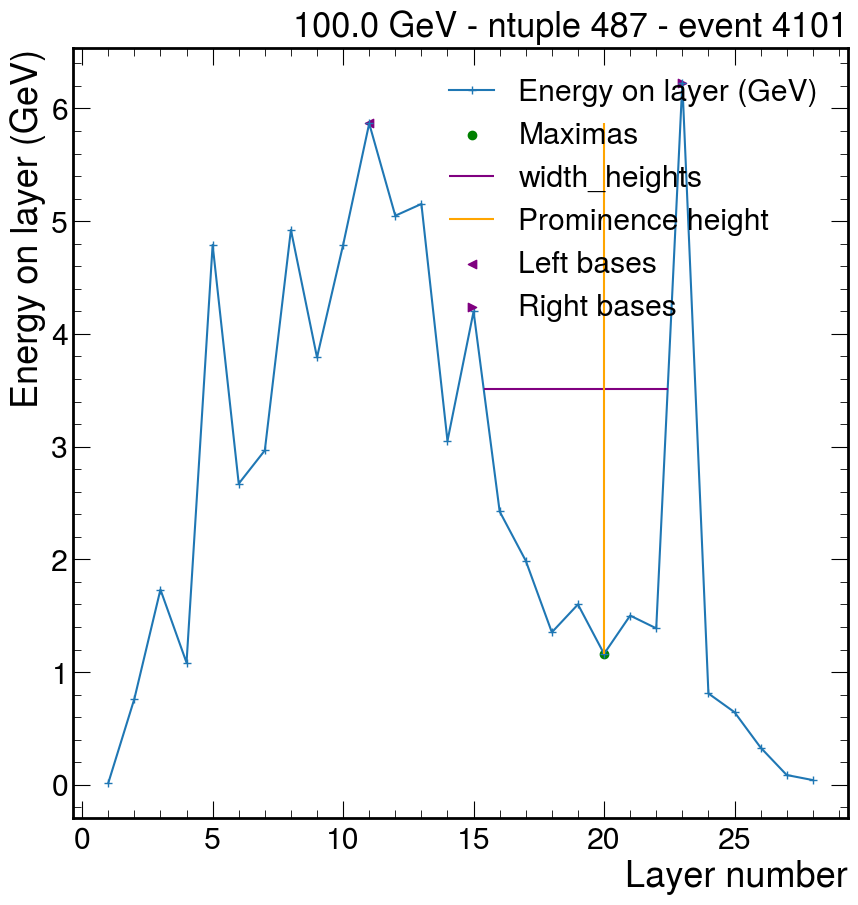

In [17]:
plotRandomEvent(extractMostProminentPeak(failing).query("prominences > 3 and widths > 2"))

In [21]:
filterApplier = FilterApplier(peaks_df, energyPerLayer_df, [FilterLowBaseHeight(minFractionOfMaxLayerEnergy=0.5),
                                                FilterNoisyCellsPeaks()])
peaks_df_filtered = filterApplier.applyAllFilters()

FilterLowBaseHeight - efficiency 15.4%
FilterLargeNarrowPeaks - efficiency 99.6%


In [22]:
filtered_peaks_mostProminent = extractMostProminentPeak(peaks_df_filtered)

In [20]:
plotEvt(30048, filtered_peaks_mostProminent)

30048


KeyError: 30048

In [23]:
filtered_peaks_mostProminent.query("prominences > 0.8*beamEnergy/28 and widths > 2").sort_values(["beamEnergy", "ntupleNumber", "event"])

,ntupleNumber,event,beamEnergy,rechits_energy_maxLayer,peak_index,prominences,left_bases,right_bases,widths,width_heights,left_ips,right_ips
eventInternal,,,,,,,,,,,,
204,436,47,20.0,1.867705,9.0,0.915170,4.0,11.0,2.289204,-1.273084,7.751067,10.040271
217,436,167,20.0,2.226545,7.0,0.661523,5.0,10.0,2.364867,-1.759910,6.474274,8.839141
240,436,314,20.0,1.709458,7.0,0.659168,3.0,16.0,3.210459,-0.870861,6.451423,9.661883
289,436,704,20.0,1.815625,9.0,0.751181,5.0,15.0,2.999487,-0.707897,8.284288,11.283774
341,436,1120,20.0,2.214473,6.0,0.592533,4.0,8.0,2.697818,-1.831633,4.603940,7.301758
...,...,...,...,...,...,...,...,...,...,...,...,...
49732,509,1951,150.0,9.353869,11.0,4.629078,5.0,18.0,4.574291,-5.549105,8.343316,12.917608
89497,666,5275,200.0,18.984428,2.0,8.620611,1.0,8.0,2.472765,-9.994621,1.500000,3.972765
89961,672,1891,200.0,19.739340,19.0,10.185649,8.0,20.0,4.508646,-8.386567,14.991354,19.500000


In [ ]:
printDashLinksFromDf(filtered_peaks_mostProminent.query("prominences > 5 and widths > 2").sort_values(["beamEnergy", "ntupleNumber", "event"]), "data")

https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=80&ntuple=467&event=3527
https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=80&ntuple=661&event=1895
https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=100&ntuple=483&event=151
https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=100&ntuple=483&event=1047
https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=100&ntuple=483&event=1162
https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=100&ntuple=483&event=2050
https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=100&ntuple=483&event=2407
https://hgcal-tb18-clue3d-visualization.web.cern.ch/?clueParam=cmssw&datatype=data&beamEnergy=100&ntuple=483&event=4637
https://hgcal-tb18-clue3d-visualization.web

10329


(array([11, 25]),
 {'prominences': array([0.74769461, 0.05988721]),
  'left_bases': array([6, 6]),
  'right_bases': array([17, 26]),
  'widths': array([5.94238406, 1.53690903]),
  'width_heights': array([-1.0001871, -0.0299436]),
  'left_ips': array([10.12687294, 23.96309097]),
  'right_ips': array([16.069257, 25.5     ])})

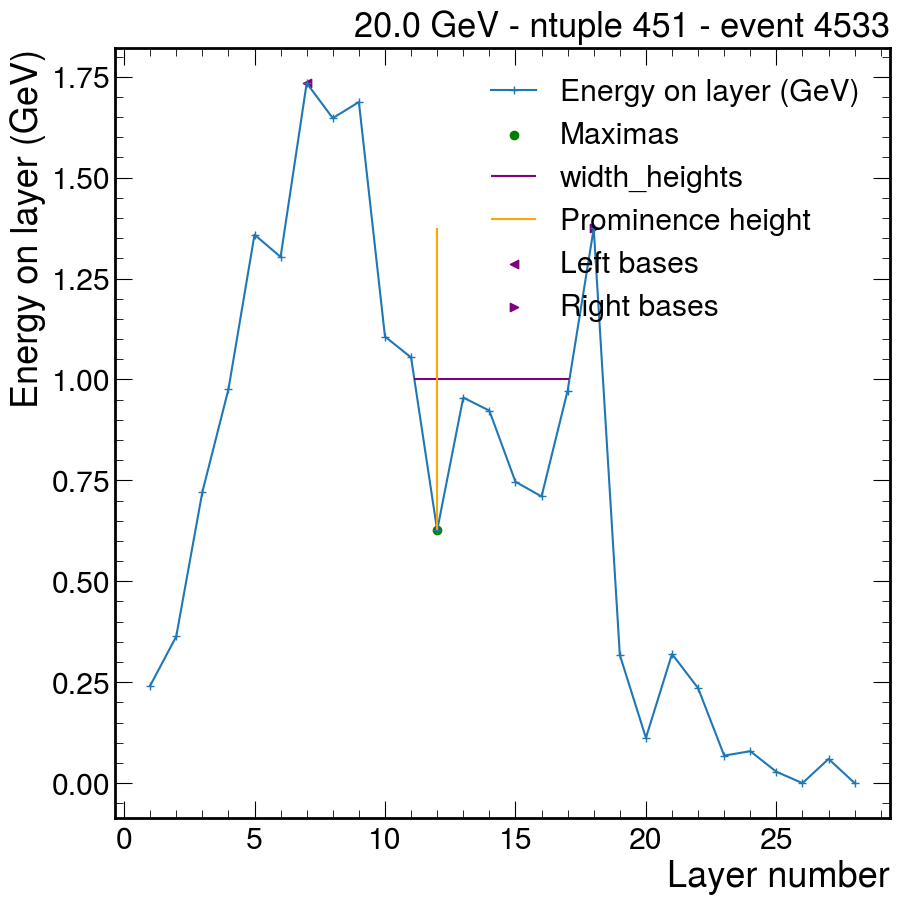

In [24]:
plotRandomEvent(filtered_peaks_mostProminent.query("prominences > 0.8*beamEnergy/28 and widths > 2"))

In [35]:
from hists.custom_hists import beamEnergiesAxis
h = hist.Hist(beamEnergiesAxis(), hist.axis.Regular(20, 0, 8, name="dipLengthMedian", label="Length of dip, at median height (in layers)"), 
              hist.axis.Regular(30, 0., 0.07, name="dipRelativeProminence", label="Dip prominence as fraction of beam energy"))
h.fill(filtered_peaks_mostProminent.beamEnergy, filtered_peaks_mostProminent.widths, filtered_peaks_mostProminent.prominences/filtered_peaks_mostProminent.beamEnergy)

Hist(
  IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'),
  Regular(20, 0, 8, name='dipLengthMedian', label='Length of dip, at median height (in layers)'),
  Regular(30, 0, 0.07, name='dipRelativeProminence', label='Dip prominence as fraction of beam energy'),
  storage=Double()) # Sum: 13885.0 (13909.0 with flow)

In [36]:
def plotLengthProminencce(h:hist.Hist, beamEnergy):
    plt.figure()
    if not isinstance(beamEnergy, list):
        beamEnergy = [beamEnergy]

    h = h[{"beamEnergy":[hist.loc(x) for x in beamEnergy], #"dipProminence":hist.rebin(2)
           }].project("dipLengthMedian", "dipRelativeProminence")
    hep.hist2dplot(h, #norm=matplotlib.colors.LogNorm()
                   )
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
    hep.cms.text("Preliminary")
    
    hep.cms.lumitext(f"{beamEnergy} GeV - TB")

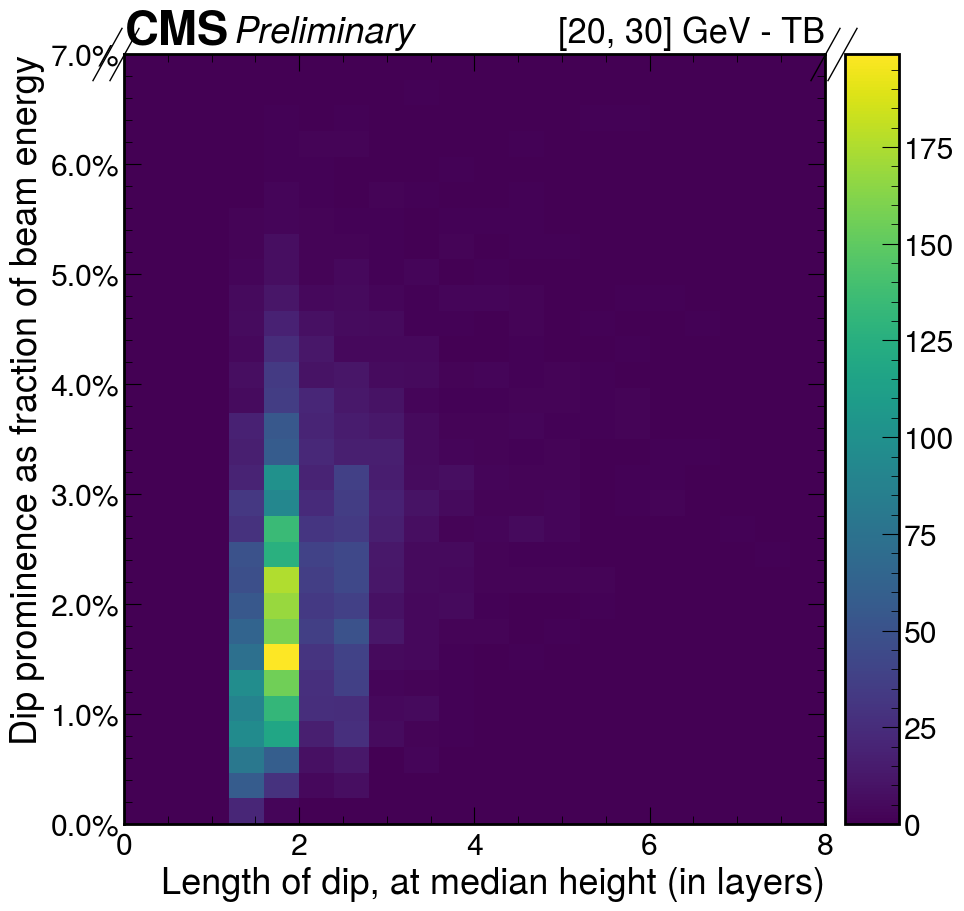

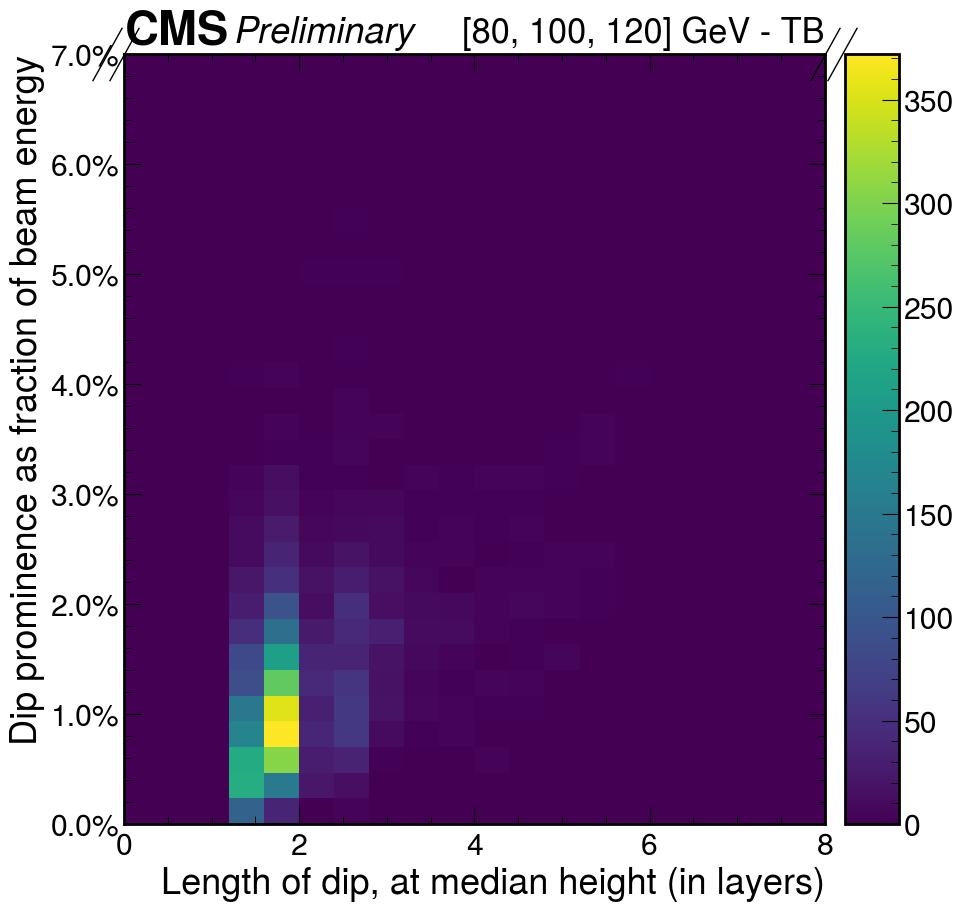

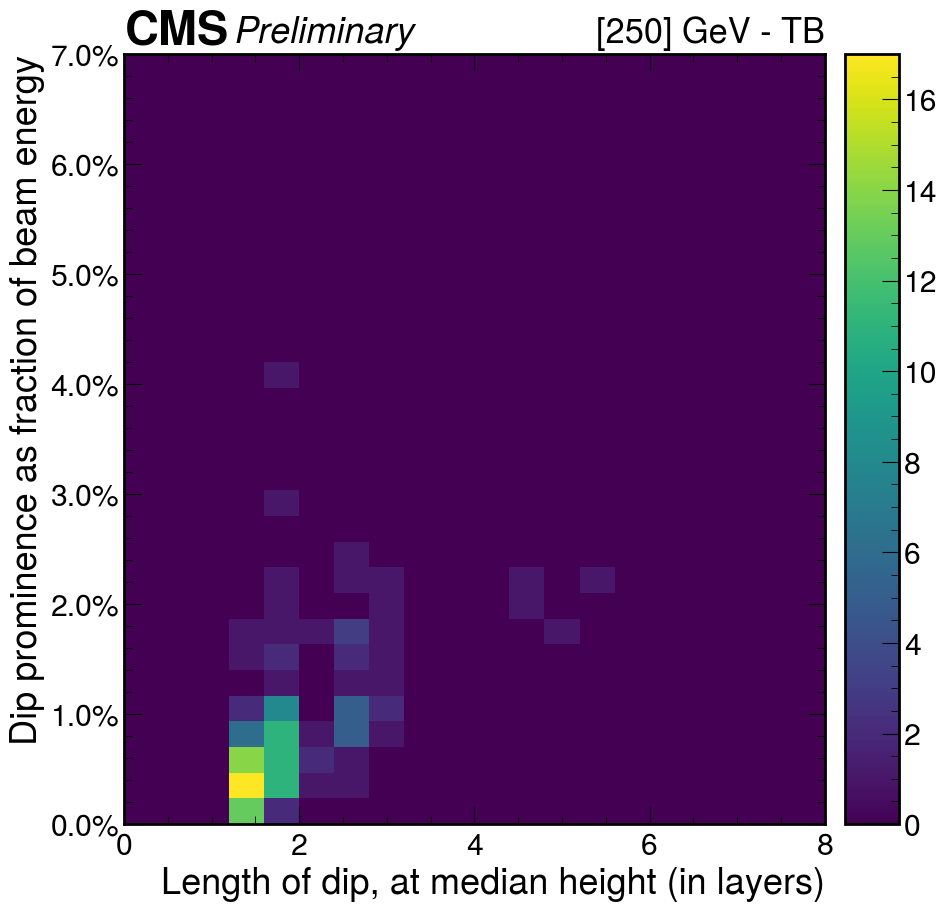

In [37]:
plotLengthProminencce(h, [20, 30])
plotLengthProminencce(h, [80, 100, 120])
plotLengthProminencce(h, [250])